# Building a Coauthorship Graph for COVID-19 Publications

This notebook walks through the data processing and output of a simple network graph for a scholarly coauthorship network.  The dataset contains the top 200 most cited research papers and pre-prints related to COVID-19 as of December 8th, 2020.  The data were published by the [Dimensions.ai](https://www.dimensions.ai/) team on Google BigQuery at [this URL](https://console.cloud.google.com/marketplace/product/digitalscience-public/covid-19-dataset-dimensions).  They were extracted with this [SQL Query](https://github.com/Frodnar/frodnar.github.io/blob/master/covid19_top20cited_scopus_like.sql).

The data are forced to fit the Scopus input format for the Python package `metaknowledge`.  The package can be installed in the usual way via `pip` or for other options see [the documentation](https://metaknowledge.readthedocs.io/en/latest/install.html).  `metaknowledge` should automatically install `networkx` per its requirements.

The output files can be used with a graph visualization suite like [Gephi](https://gephi.org/) to create an interactive visualization such as [this one](https://bit.ly/36VyBck), made from this very data.  Note that you need disk write access to follow this tutorial.


In [25]:
# Start by importing required packages

import metaknowledge as mk
import networkx as nx
import zipfile
import csv
from io import BytesIO
from urllib import request

In [26]:
# Build the RecordCollection from CSV file.  Metaknowledge detects which file(s) in the directory are in the required format.

RC = mk.RecordCollection('scopus_like_records/', cached = True)
print(RC.glimpse())

RecordCollection glimpse made at: 2020-12-10 20:12:48
200 Records from files-from-C:\Users\a7htczz\De

Top Authors
1 Drosten Christian
2 Yu Ting
2 Yuen Kwok-Yung
2 Liu Lei
2 Hu Yu
2 Shan Hong
3 Wang Tao
3 Yang Yang
3 Tan Wenjie

Top Journals
1 New England Journal of Medicine
2 The Lancet
3 JAMA
4 Radiology
4 Nature
5 Cell
5 Science
6 Journal of Medical Virology
6 The Lancet Infectious Diseases

Top Cited


In [27]:
# Build the coAuthor network. Each node is an author and an edge represents a coauthorship.

coAuths = RC.networkCoAuthor()
print(mk.graphStats(coAuths))

Nodes: 2521
Edges: 38783
Isolates: 1
Self loops: 0
Density: 0.0122095
Transitivity: 0.9148


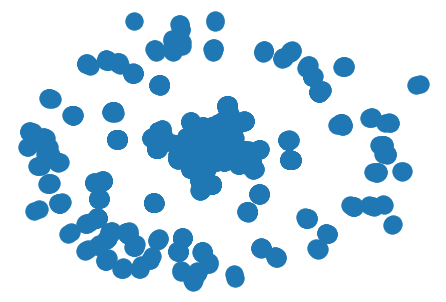

In [28]:
# Quickly visualize using the draw_spring function from networkx package.  (This one take awhile.) Hmmm... not very helpful.  

nx.draw_spring(coAuths)

In [29]:
# Instead, let's save csv files with nodes and edges for later visualization in another program like Gephi.
file_name = 'coAuthor_graph'
mk.writeGraph(coAuths, file_name)

In [30]:
# Let's take this one step further and analyze authors by gender. How many authors are present?  How many unique authors?

auth_names_all = []
for record in RC:
    try:
        for i in range(len(record['Authors'])):
            auth_names_all.append(record['Authors'][i])
    except:
        pass
print("Authors: " + str(len(auth_names_all)))

auth_names = set(auth_names_all)
print("Unique authors: " + str(len(auth_names)))


Authors: 2940
Unique authors: 2521


In [31]:
#Load American names dataset for assigning probable genders to authors.

dataURL = 'https://github.com/UWNETLAB/globalnamedata/archive/0.3.zip'
americanNamesPath = 'globalnamedata-0.3/assets/usprocessed.csv'

csvFields = [
    'Name',
    'years.appearing',
    'count.male',
    'count.female',
    'prob.gender',
    'obs.male',
    'est.male',
    'upper',
    'lower'
]

zipFile = BytesIO(request.urlopen(dataURL).read())
namesFile = zipfile.ZipFile(zipFile).open(americanNamesPath)
with open('namesData.csv', 'wb') as f:
    f.write(namesFile.read())
    print("Data downloaded successfully!")

retDict = {}
with open('namesData.csv') as f:
    reader = csv.DictReader(f, fieldnames = csvFields)
    next(reader)
    for line in reader:
        retDict[line['Name'].title()] = line['prob.gender']
    print("Data read successfully!")

Data downloaded successfully!
Data read successfully!


In [32]:
# Attempt to assign probable gender for each (international) author.  Many 'Unknown' since we're using American names assignment data.

auth_gen_sum = {'Male': 0, 'Female': 0, 'Unknown': 0}

count = nx.get_node_attributes(coAuths, 'count')
auth_prob_genders = {}
for name in auth_names:
    gender = retDict.get(name.split(' ')[1].split(' ')[0].title(), 'Unknown')
    auth_gen_sum[gender] += 1
    auth_prob_genders[name] = {'gender': gender, 'count': count[name]}

print(auth_gen_sum)
print(list(auth_prob_genders.items())[:5])

{'Male': 833, 'Female': 455, 'Unknown': 1233}
[('Green Will', {'gender': 'Male', 'count': 20}), ('Wang Yaxin', {'gender': 'Unknown', 'count': 12}), ('Guo Yan-Rong', {'gender': 'Unknown', 'count': 1}), ('Kluge Stefan', {'gender': 'Male', 'count': 27}), ('Sutherland Aaron', {'gender': 'Male', 'count': 8})]


In [33]:
#Update the node (author) attributes of coAuths, do a quick check, then write to a new set of csv's with our graph.

nx.set_node_attributes(coAuths, auth_prob_genders)
gender = nx.get_node_attributes(coAuths, "gender")
print(gender['Fraser James S.'])

mk.writeGraph(coAuths, 'coAuthor_graph_w_prob_genders')

Male
